In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist
from enum import Enum

In [2]:
from core import *
use_cuda = torch.cuda.is_available()

Use GPU: False


In [0]:
net = BayesianNN(
    nn_input_size=1, 
    layer_config=[50, 50, 1], 
    activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.NONE], 
    prior_type=PriorType.MIXTURE)
if use_cuda:
    net = net.cuda()

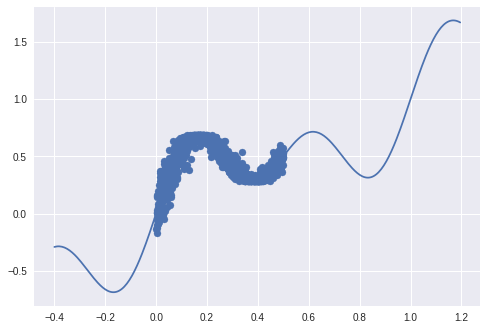

In [4]:
# Regression curves data

SAMPLE_SIZE = 1200

def noisy_function(x):
  epsilon = dist.Normal(0, 0.02).sample(torch.Size([SAMPLE_SIZE]))
  return (x + 0.3 * torch.sin(2 * math.pi * (x + epsilon)) +
          0.3 * torch.sin(4 * math.pi * (x + epsilon)) + epsilon)

def true_function(x):
  return x + 0.3 * torch.sin(2 * math.pi * x) + 0.3 * torch.sin(4 * math.pi * x)
 
trainfeatures = dist.Uniform(
    torch.tensor([0.0]), torch.tensor([0.5])).sample(torch.Size([SAMPLE_SIZE])).flatten()
trainlabels = noisy_function(trainfeatures) 

true_range = torch.arange(-0.4, 1.2, 0.005)
true_labels = true_function(true_range)

if use_cuda:
  true_range = true_range.cuda()

plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy())
plt.plot(true_range.cpu().numpy(), true_labels.flatten().cpu().numpy())
plt.plot()

trainfeatures = trainfeatures.view([SAMPLE_SIZE, 1])
trainlabels = trainlabels.view([SAMPLE_SIZE, 1])
trainset = torch.utils.data.TensorDataset(trainfeatures, trainlabels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=120,
                                          shuffle=True, num_workers=2)

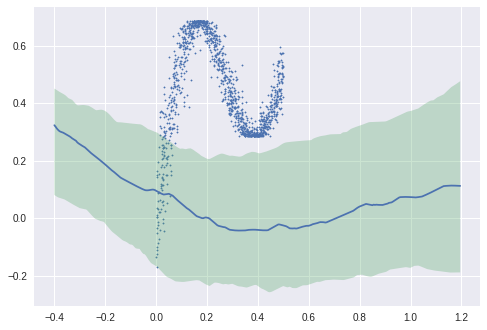

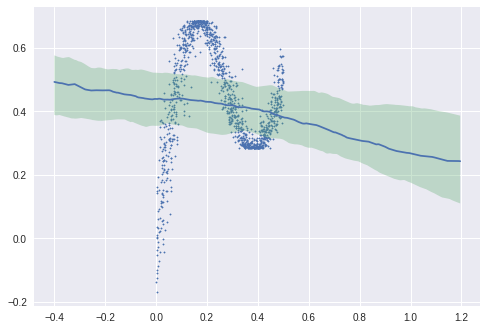

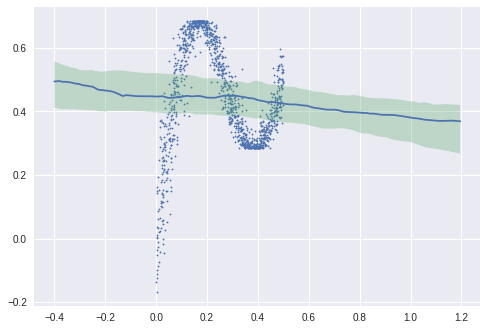

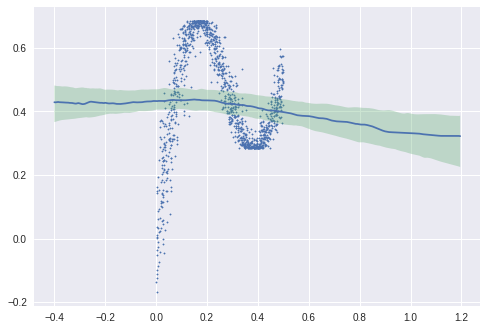

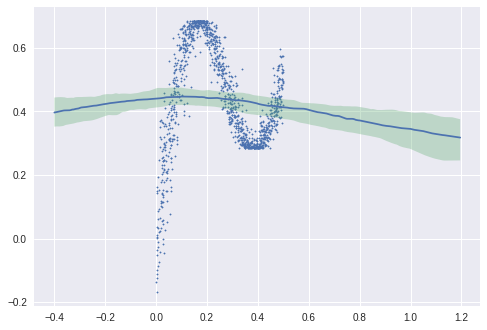

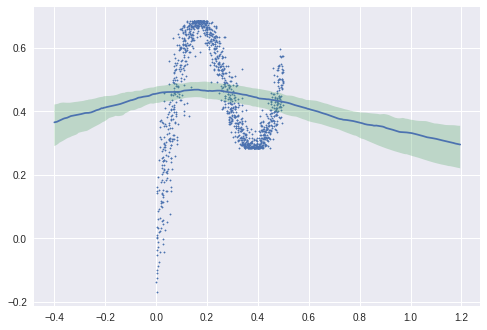

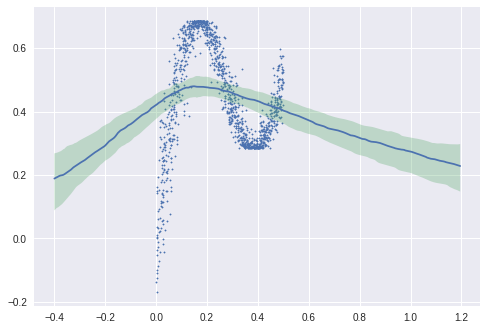

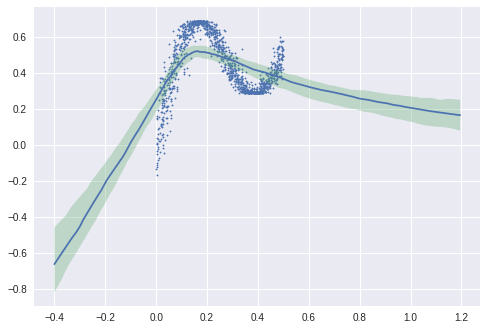

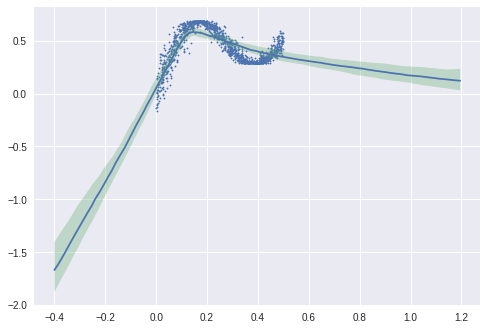

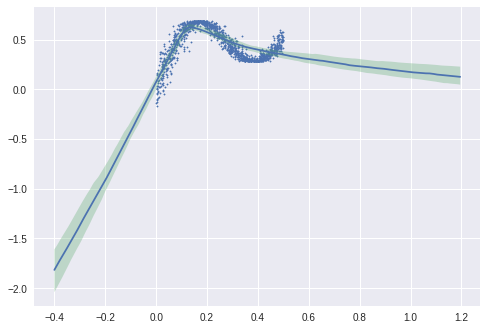

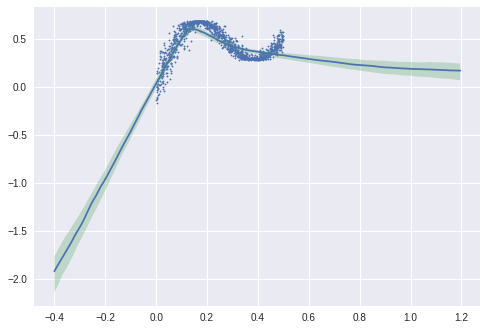

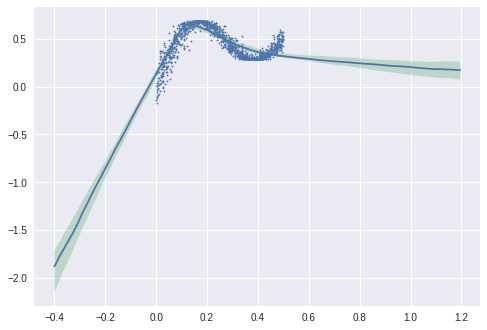

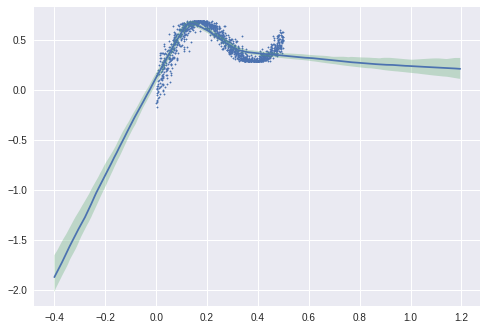

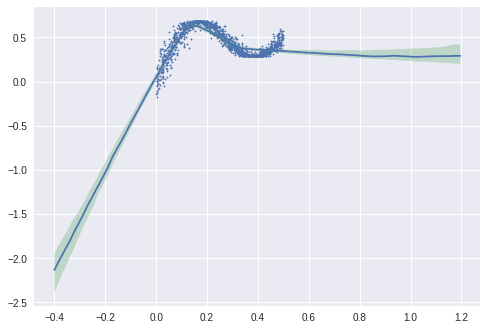

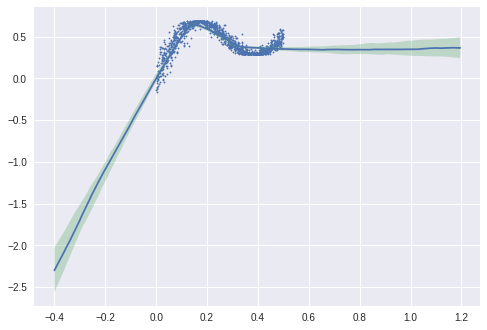

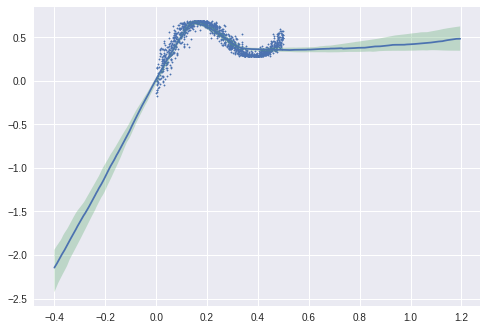

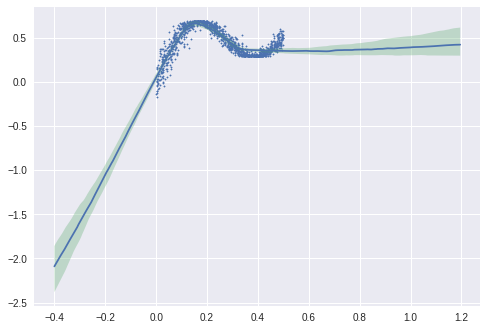

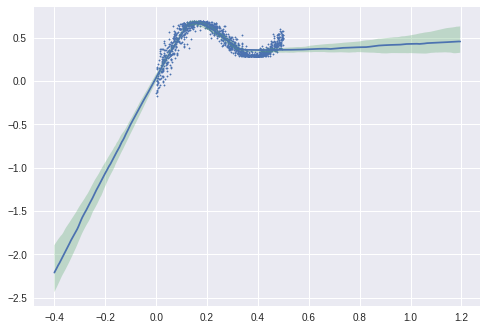

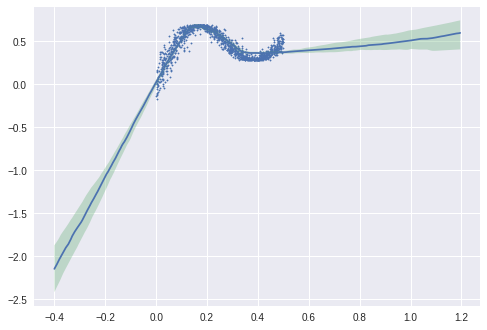

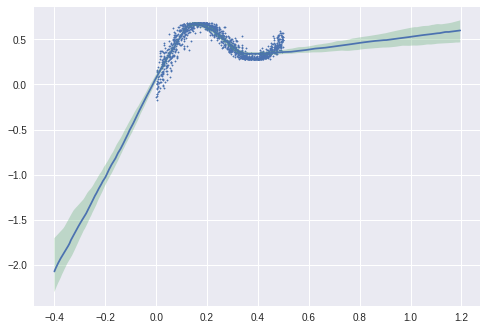

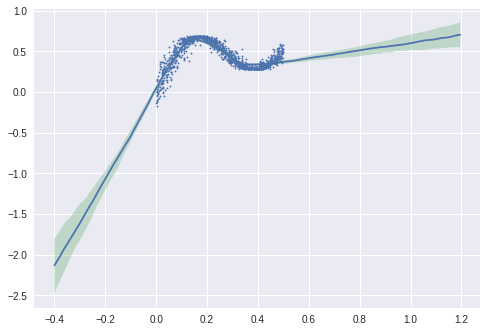

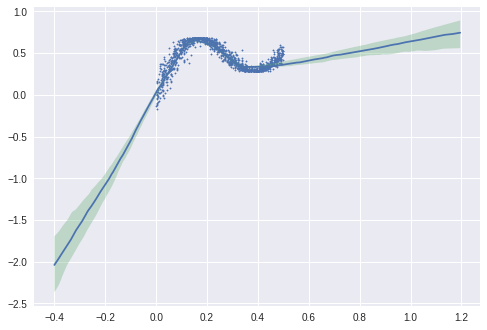

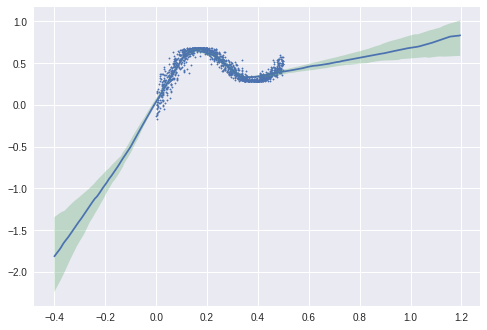

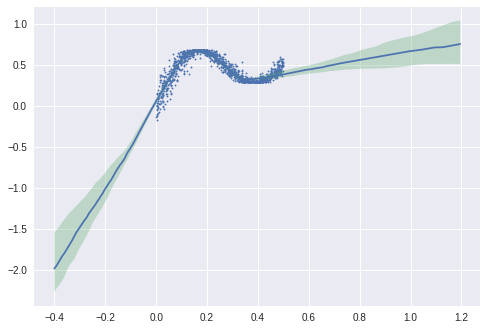

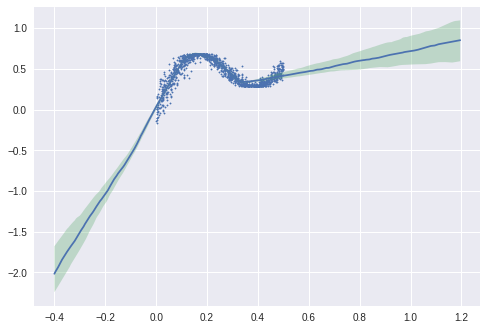

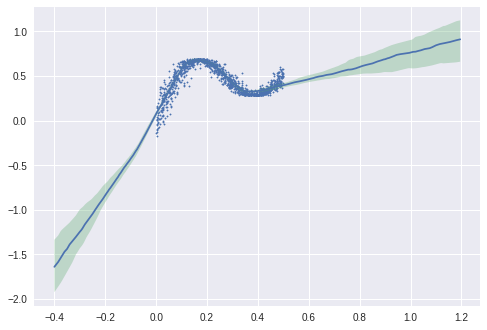

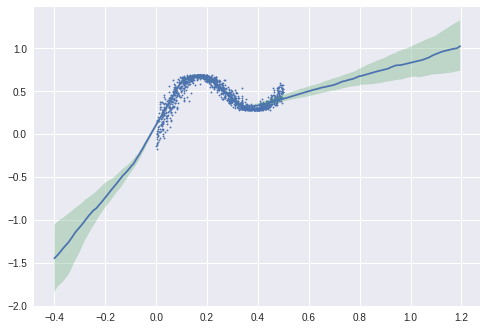

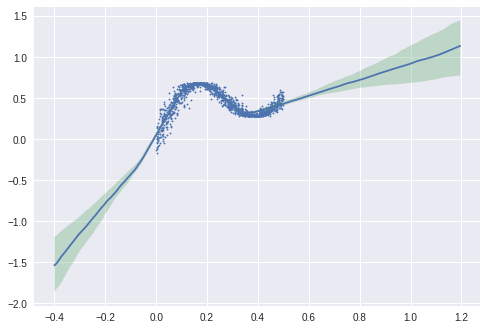

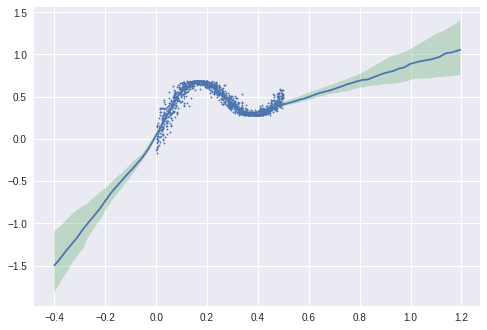

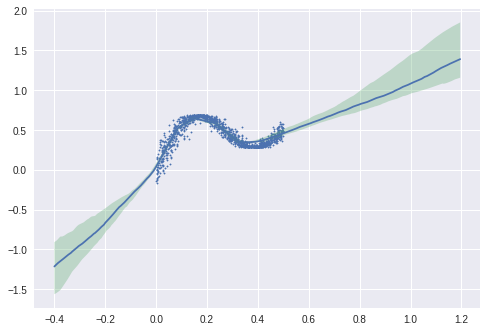

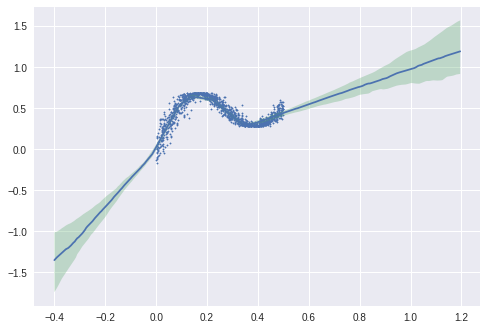

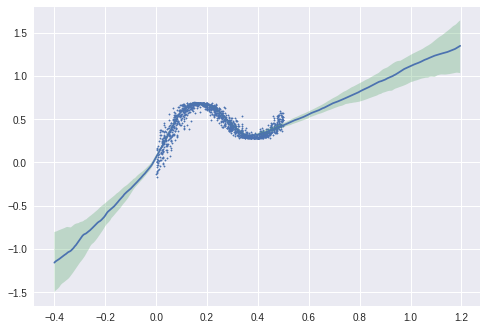

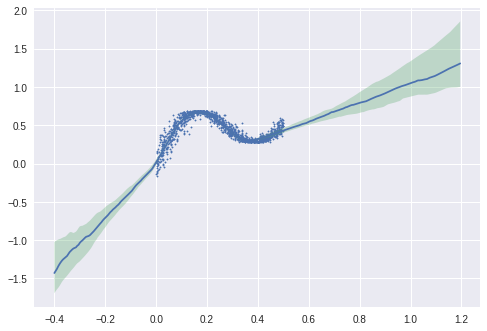

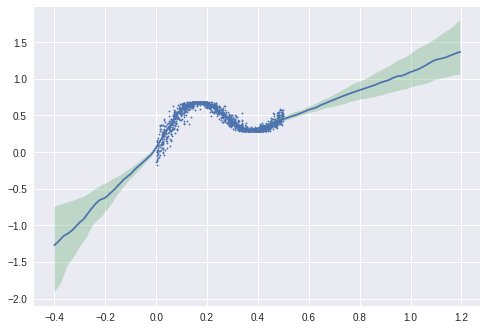

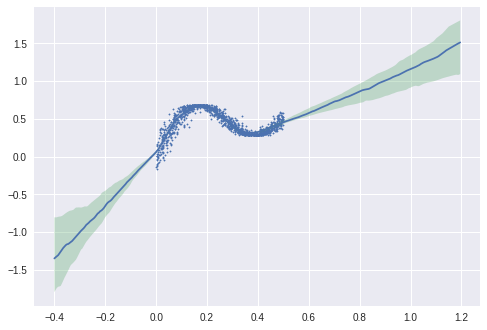

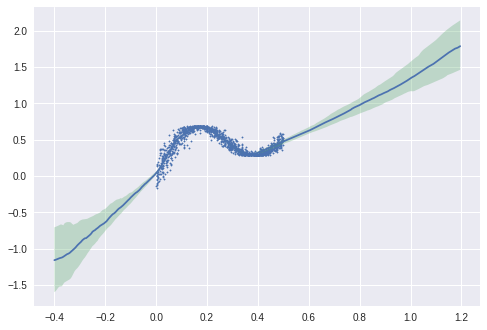

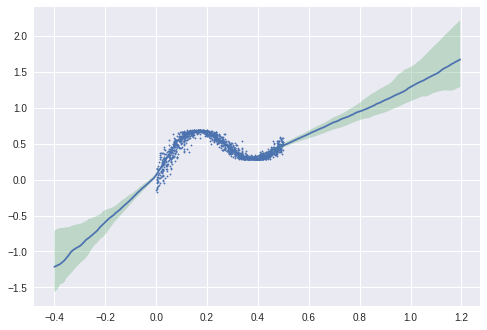

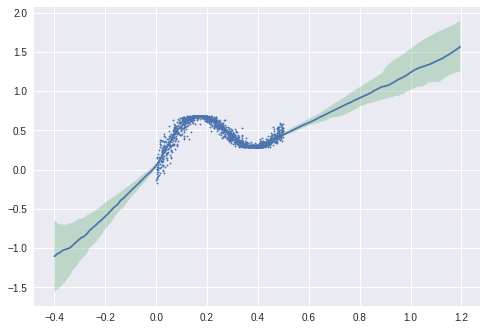

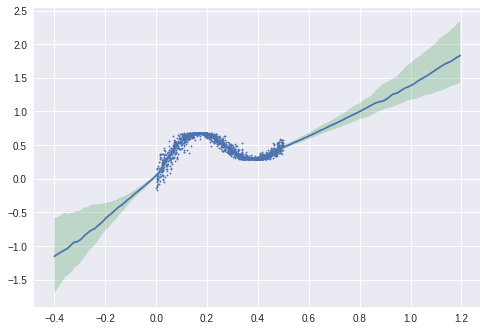

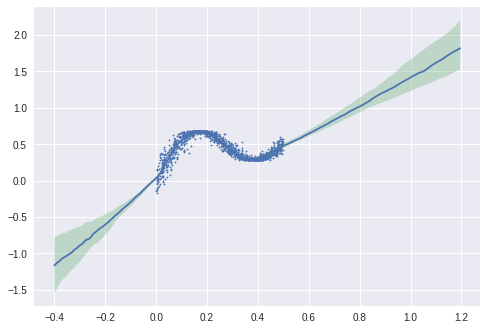

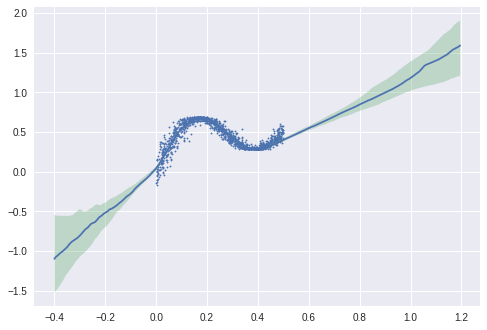

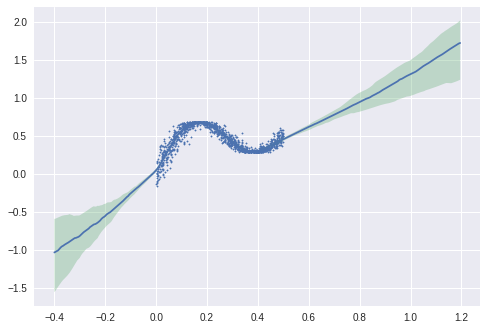

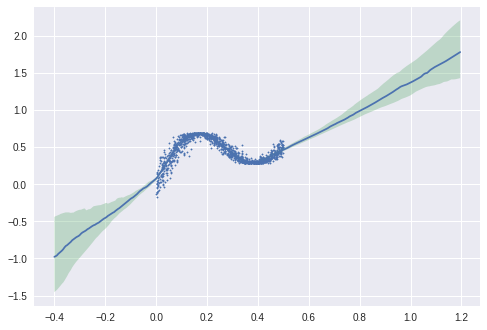

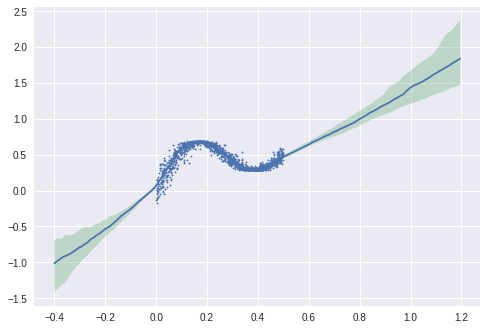

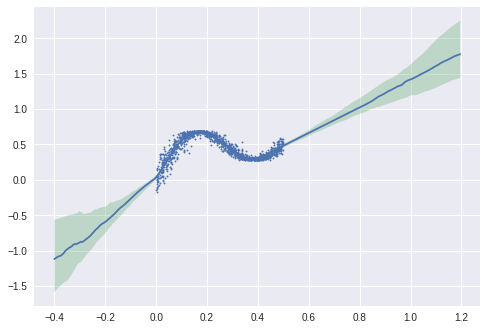

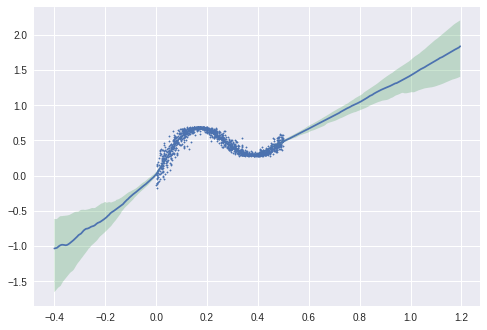

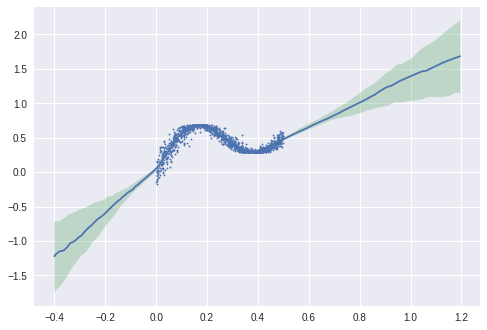

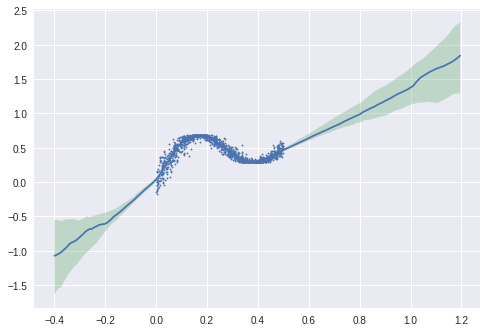

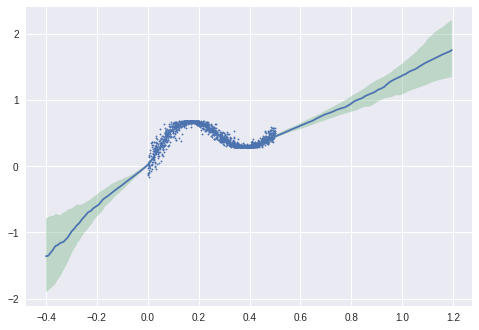

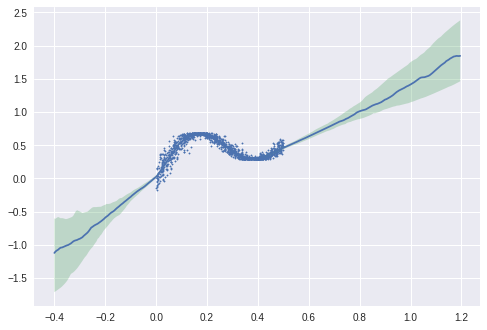

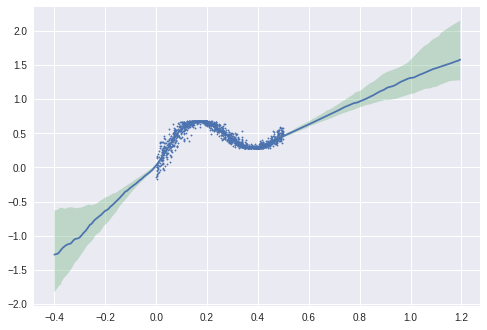

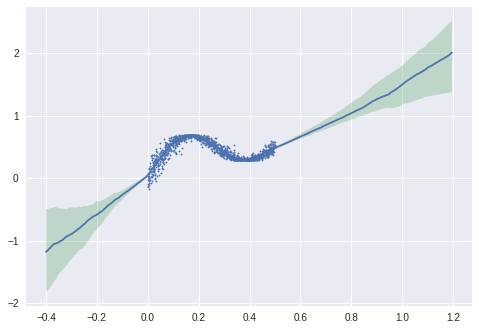

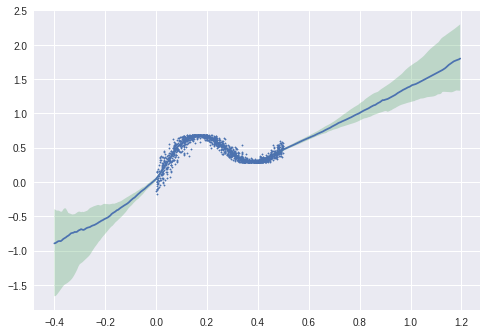

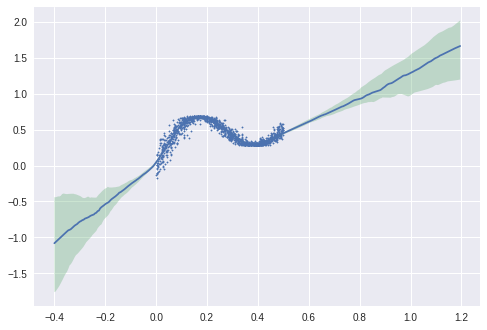

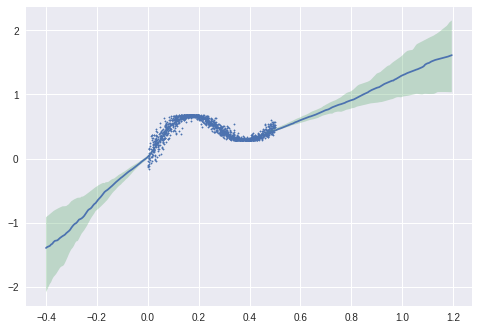

In [0]:
# Training

optimizer = optim.Adam(net.parameters(), lr=0.01)
net.train()

for epoch in range(30001):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss, _, _ = net.cost_function(inputs, labels, num_samples=2, num_batches=len(trainloader))
        loss.backward()
        optimizer.step()
    
    if(epoch%10==0):
        net.train()
        outputs = []
        for sample_count in range(100):
          outputs.append(net(true_range.view([320, 1])))
        outputs = torch.cat(outputs, dim=1).detach().cpu().numpy()
        output_median = np.median(outputs, axis=1)
        output_lower = np.percentile(outputs, 25, axis=1)
        output_higher = np.percentile(outputs, 75, axis=1)
        plt.plot(true_range.flatten().cpu().numpy(), output_median)
        plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy(),s = 2)
        plt.fill_between(true_range.flatten().cpu().numpy(), output_lower, output_higher, interpolate=True, alpha=0.3)
        plt.plot()
        plt.show()

print('Finished Training')